\hfill Department of Statistics

\hfill Jaeyeong Kim

In [1]:
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
import pandas as pd

def sigmoid(x):
    return 1/(1+np.exp(-np.float32(x)))

def score(X_train_scaled, X_valid_scaled, Y_train, Y_valid, w):
    #get shapes of the train and the validation data sets
    (m,   n) = X_train.shape
    (m1, n1) = X_valid.shape
    
    #save prediction of Y
    Y_predict_train = np.zeros((m,1))
    Y_predict_valid = np.zeros((m1,1))
        
    # predict Y of the train set and the test set
    h_train = sigmoid(np.dot(X_train_scaled, w))
    h_valid = sigmoid(np.dot(X_valid_scaled, w))
    
    Y_predict_train[h_train > 0.5] = 1
    Y_predict_train[h_train <= 0.5] = -1

    Y_predict_valid[h_valid > 0.5] = 1
    Y_predict_valid[h_valid <= 0.5] = -1
            
            
    #calculate prediction scores
    Y_score_train = 0
    Y_score_valid = 0
    
    for j in range(m):
        if Y_predict_train[j] == np.array(Y_train)[j]:
            Y_score_train += 1
        else :
            continue

    for j in range(m1):
        if Y_predict_valid[j] == np.array(Y_valid)[j]:
            Y_score_valid += 1
        else :
            continue
    
    score_train = Y_score_train / m
    score_valid = Y_score_valid / m1

    return score_train, score_valid


def fsa(X_train, X_valid, Y_train, Y_valid, \
                        learning_rate, iteration, eta0, k, has_loss):
    #get shapes of the train and the validation data sets
    m, n = X_train.shape
    m1,n1 = X_valid.shape

    #set w0 = 0
    w = np.zeros((n,1))
    loss = []
    
    for i in range(iteration):
        xb = np.dot(X_train,w)
        yxb = np.multiply(Y_train, xb)
        
        #make dummy function (if yxb<=1 then I = 1, else I = 0)
        I = np.copy(yxb)
        I[yxb<=1] = 1
        I[yxb>1] = 0
        
        #calculate losses
        if has_loss == True:
           
            loss1 = 1/m * np.sum(np.multiply(I, \
                np.log(np.float32(1+np.power(yxb-1,2))))) + 0.001 * 1/m * np.dot(w.T, w)
            loss.append([i+1, loss1])        

        #update w
        numerator = np.multiply(I, 2* np.multiply(Y_train,(yxb-1)))
        denominator = (1 + np.power((yxb-1),2))
        grad = np.dot(X_train.T, np.divide(numerator, denominator)) + 2 * 0.001 * w
        w = w - learning_rate / m * grad
        

        #feature selection
        if w.shape[0] > k:
            w1 = w.reshape(-1)
            sb = w1[:, np.argsort(-abs(w1))].reshape(-1)
            M = k + int((n-k) * max(0, (iteration - 2*(i+1))/(2*(i+1)*eta0 + iteration)))
            if w.shape[0] > M:
                j = np.where(np.abs(w1) >= abs(sb[:,M-1]))
                X_train = np.where(np.abs(w1) >= abs(sb[:,M-1]), X_train, None)
                X_train = pd.DataFrame(X_train)
                X_train = np.matrix(X_train.dropna(axis = 1))
                
                X_valid = np.where(np.abs(w1) >= abs(sb[:,M-1]), X_valid, None)
                X_valid = pd.DataFrame(X_valid)
                X_valid = np.matrix(X_valid.dropna(axis = 1))
                
                w1 = w1[j]
                w = w1.T

            else:
                continue
        else:
            continue
        
  
    score_train, score_valid = score(X_train, \
                                X_valid, Y_train, Y_valid, w)
    error_result = [k, 1-score_train, 1-score_valid]
    
    return error_result, loss

## gisette

In [8]:
# Reading in the gisette data set
X_train = pd.read_csv('gisette\gisette_train.data', header = None,\
                      delimiter = ' ').dropna(axis='columns')
Y_train = pd.read_csv('gisette\gisette_train.labels', header = None)

X_valid = pd.read_csv('gisette\gisette_valid.data', header = None, \
                      delimiter = ' ').dropna(axis='columns')
Y_valid = pd.read_csv('gisette\gisette_valid.labels', header = None)

ks = np.array([10, 30, 100, 300])
error_results = np.array(np.zeros((ks.size,3)))
ws = np.array(np.zeros((ks.size,2)))

i = 0

#normalize the train and validation data sets.
X_train = np.matrix(preprocessing.scale(X_train))
X_valid = np.matrix(preprocessing.scale(X_valid))
Y_train = np.matrix(Y_train)
Y_valid = np.matrix(Y_valid)

# Run logistic regression
for k in ks:
    #X_train, X_valid, Y_train, Y_valid, learning_rate, iteration, eta0, k, has_loss
    if k == 10:
        error_result, loss_10 = fsa(X_train, X_valid, Y_train, Y_valid, \
                        1, 500, 20, k, True)
    else :
        error_result, loss = fsa(X_train, X_valid, Y_train, Y_valid, \
                        1, 500, 20, k, False)
    error_results[i] = error_result
    i += 1

x = pd.DataFrame(data = error_results, columns = ['k',\
                                'error_train', 'error_valid'])
y = pd.DataFrame(data = loss_10, columns = ['iteration', 'loss'])

x

C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app
C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  app.launch_new_instance()


,k,error_train,error_valid
0,10.0,0.075000,0.082
1,30.0,0.036333,0.047
2,100.0,0.010333,0.026
3,300.0,0.004167,0.017


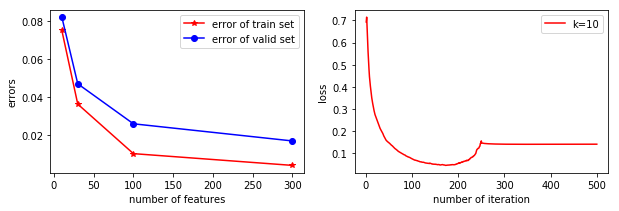

In [9]:
# Plot the results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(x['k'], x['error_train'], 'r-*', label='error of train set')
plt.plot(x['k'], x['error_valid'], 'b-o', label='error of valid set')
plt.xlabel('number of features')
plt.ylabel('errors')
plt.legend()

plt.subplot(122)
plt.plot(y['iteration'], y['loss'], 'r-', label='k=10')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

## madelon

In [2]:
# Reading in the MADELON data set
X_train = pd.read_csv('madelon\madelon_train.data', header = None,\
                      delimiter = ' ').dropna(axis='columns')
Y_train = pd.read_csv('madelon\madelon_train.labels', header = None)

X_valid = pd.read_csv('madelon\madelon_valid.data', header = None, \
                      delimiter = ' ').dropna(axis='columns')
Y_valid = pd.read_csv('madelon\madelon_valid.labels', header = None)

ks = np.array([10, 30, 100, 300])
error_results = np.array(np.zeros((ks.size,3)))
ws = np.array(np.zeros((ks.size,2)))

i = 0

    
#normalize the train and validation data sets.
X_train = np.matrix(preprocessing.scale(X_train))
X_valid = np.matrix(preprocessing.scale(X_valid))
Y_train = np.matrix(Y_train)
Y_valid = np.matrix(Y_valid)


# Run logistic regression
for k in ks:
    #X_train, X_valid, Y_train, Y_valid, learning_rate, iteration, eta0, k, has_loss
    if k == 10:
        error_result, loss_10 = fsa(X_train, X_valid, Y_train, Y_valid, \
                        0.01, 500, 10, k, True)
    else :
        error_result, loss = fsa(X_train, X_valid, Y_train, Y_valid, \
                        0.01, 500, 10, k, False)
    error_results[i] = error_result
    i += 1

x = pd.DataFrame(data = error_results, columns = ['k',\
                                'error_train', 'error_valid'])
y = pd.DataFrame(data = loss_10, columns = ['iteration', 'loss'])

x

C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  app.launch_new_instance()
C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.


,k,error_train,error_valid
0,10.0,0.3800,0.401667
1,30.0,0.3475,0.415000
2,100.0,0.3040,0.443333
3,300.0,0.2525,0.423333


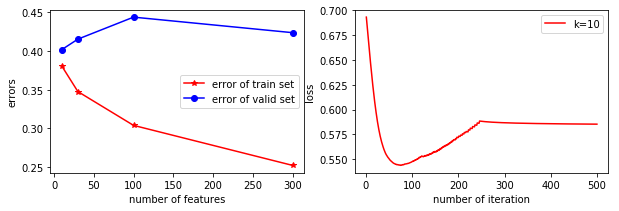

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(x['k'], x['error_train'], 'r-*', label='error of train set')
plt.plot(x['k'], x['error_valid'], 'b-o', label='error of valid set')
plt.xlabel('number of features')
plt.ylabel('errors')
plt.legend()

plt.subplot(122)
plt.plot(y['iteration'], y['loss'], 'r-', label='k=10')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()
plt.show()


## dexter

In [12]:
# Reading in the dexter data set
X_train = pd.read_csv('dexter\dexter_train.csv', header = None)\
                      .dropna(axis='columns')
Y_train = pd.read_csv('dexter\dexter_train.labels', header = None)

X_valid = pd.read_csv('dexter\dexter_valid.csv', header = None)\
                      .dropna(axis='columns')
Y_valid = pd.read_csv('dexter\dexter_valid.labels', header = None)

ks = np.array([10, 30, 100, 300])
error_results = np.array(np.zeros((ks.size,3)))
ws = np.array(np.zeros((ks.size,2)))

i = 0

#normalize the train and validation data sets.
X_train = np.matrix(preprocessing.scale(X_train))
X_valid = np.matrix(preprocessing.scale(X_valid))
Y_train = np.matrix(Y_train)
Y_valid = np.matrix(Y_valid)

# Run logistic regression
for k in ks:
    #X_train, X_valid, Y_train, Y_valid, learning_rate, iteration, eta0, k, has_loss
    if k == 10:
        error_result, loss_10 = fsa(X_train, X_valid, Y_train, Y_valid, \
                        3, 500, 10, k, True)
    else :
        error_result, loss = fsa(X_train, X_valid, Y_train, Y_valid, \
                        3, 500, 10, k, False)
    error_results[i] = error_result
    i += 1

x = pd.DataFrame(data = error_results, columns = ['k',\
                                'error_train', 'error_valid'])
y = pd.DataFrame(data = loss_10, columns = ['iteration', 'loss'])

x

C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app
C:\Users\Jay_Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  app.launch_new_instance()


,k,error_train,error_valid
0,10.0,0.130000,0.180000
1,30.0,0.046667,0.113333
2,100.0,0.003333,0.083333
3,300.0,0.000000,0.080000


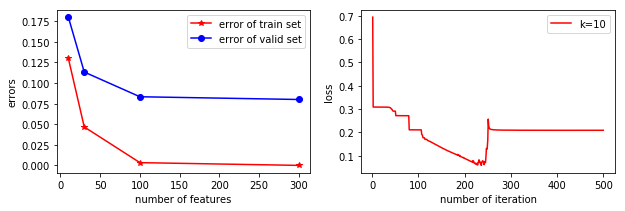

In [13]:
# Plot the results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(x['k'], x['error_train'], 'r-*', label='error of train set')
plt.plot(x['k'], x['error_valid'], 'b-o', label='error of valid set')
plt.xlabel('number of features')
plt.ylabel('errors')
plt.legend()

plt.subplot(122)
plt.plot(y['iteration'], y['loss'], 'r-', label='k=10')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()
plt.show()